# Part 2 -  Model creation
In this part we are going to create the neural network model and train. 
With respect to the preprocessed version, we introduce the cleaning part.

## Loding Libraries
Here we load the common libraries

In [1]:
import numpy as np
from grabscreen import grab_screen
import cv2
#import tdqm
import os
import pandas as pd
#from tqdm import tqdm
from collections import deque
from models import inception_v3 as googlenet
from models import alexnet2
from random import shuffle
import matplotlib.pyplot as plt

Instructions for updating:
non-resource variables are not supported in the long term
curses is not supported on this machine (please install/reinstall curses for an optimal experience)


# Cleaning of the Input file
We are going to analize the files and clean  that we have created in the part 1
Let us first select the first created file.

In [2]:
#Preprocessed image rgb color - no image filters
file_name = "preprocessed_training_data-1.npy"
#file_name = "training_data-1.npy"

In [3]:
# full file info
train_data = np.load(file_name,allow_pickle=True)

In [4]:
# This file has the following shape
train_data.shape
#(500, 2)

(500, 2)

There are 29 input componentes for each frame, we can plot the histogram for each component

In [5]:
train_hist = train_data[:]

In [6]:
train_hist.shape

(500, 2)

In [7]:
df = pd.DataFrame()
for i in range(len(train_hist)):
    row=list(train_hist[i][1])
    #print(row)
    temp = pd.DataFrame([row])
   # print(temp)
    df = pd.concat([df, temp])
df=df.reset_index(drop=True)  

In [8]:
#We count rows different to zero
(df[13] != 0).astype(int).sum(axis=0)


27

In [9]:
threshold= (df[13] != 0).astype(int).sum(axis=0)

In [10]:
print(threshold) # We assume that is different to zero

27


In [11]:
num_bins = 25
samples_per_bin = threshold
hist, bins = np.histogram(df[13], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5

total data: 500


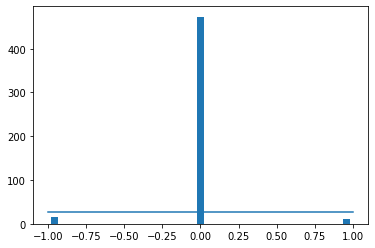

In [12]:
plt.bar(center, hist, width=0.05)
plt.plot((np.min(df[13]), np.max(df[13])), (samples_per_bin, samples_per_bin))
print('total data:', len(df[13]))

In [13]:
remove_list = []
for j in range(num_bins):
    list_ = []
    for i in range(len(df[13])):
        serie=df[13].iloc[[i]]
        ls = serie.tolist()
        if ls[0] >= bins[j] and ls[0] <= bins[j+1]:
            list_.append(i)      
    #list_ = shuffle(list_)
    list_ = list_[samples_per_bin:]
    remove_list.extend(list_)

In [14]:
print('removed:', len(remove_list))

removed: 446


In [15]:
df_removed=df.drop(remove_list, axis=0, inplace=False)

In [16]:
#We count rows different to zero
(df_removed[13] != 0).astype(int).sum(axis=0)

27

In [17]:
df.drop(df.index[remove_list], inplace=True)

print('remaining:', len(df))

remaining: 54


In [18]:
df=df.reset_index(drop=True) # We reset the index ! attention

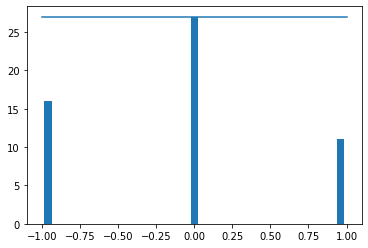

In [19]:
hist, _ = np.histogram(df[13], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(df[13]), np.max(df[13])), (samples_per_bin, samples_per_bin))

we can create the function that convert the dataframe row to numpy image array

In [20]:
def df_to_numpy_image(df_image_clean,index):
    #select the row with index label 'index'
    image_clean=df_image_clean.loc[[index]].T.to_numpy()
    lists =image_clean.tolist()
    # Nested List Comprehension to flatten a given 2-D matrix
    # 2-D List
    matrix = lists
    flatten_matrix = [val.tolist() for sublist in matrix for val in sublist]
    # converting list to array
    arr = np.array(flatten_matrix)
    return arr

In [21]:
df_image = pd.DataFrame()
for i in range(len(train_hist)):
    row=list(train_hist[i][0]) # For images  Here we lost the (i, 480, 3) shape
    #print(row)    
    temp = pd.DataFrame([row])
   # print(temp)
    df_image = pd.concat([df_image, temp])
df_image=df_image.reset_index(drop=True)
df_image_removed=df_image.drop(remove_list, axis=0, inplace=False)
df_image_clean=df_image_removed.reset_index(drop=True)
df_image_clean.shape

(54, 270)

In [25]:
image1=df_to_numpy_image(df_image_clean,50)


In [26]:
image1.shape

(270, 480, 3)

## Creation of train and test split

In [27]:
#We verify that the dimensions are the same
assert len(df) == len(df_image_clean), "The dimensions are not equal, something is wrong "

In [28]:
#train = train_data[:-50]
#test = train_data[-50:]

In [29]:
from sklearn.model_selection import train_test_split

In [30]:
X_train, X_valid, y_train, y_valid = train_test_split(df_image_clean, df, test_size=0.2, random_state=6)

In [31]:
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(y_valid)))

Training Samples: 43
Valid Samples: 11


Text(0.5, 1.0, 'Validation set')

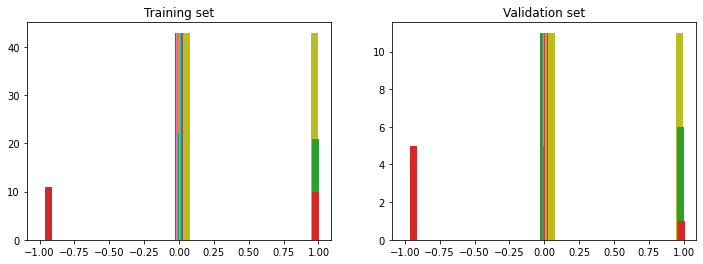

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05)
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05)
axes[1].set_title('Validation set')

We begin the train part

## Train Image part ( 4 Dimensional)

In [33]:
X_image = np.array([df_to_numpy_image(X_train,i) for i in X_train.index])

In [34]:
X_image.shape
#(101, 270, 480, 3)

(43, 270, 480, 3)

In [35]:
#(101, 270, 480, 3)  We choose only the imagen part of the train data, 
#There are 101 picturtes with resolutionn WIDTH = 480 and HEIGHT = 270 with 3 colors rgb

In [36]:
# We perform the reshape

numpy.reshape(a, newshape, order='C')

- a - Array to be reshaped.
- newshape  - The new shape should be compatible with the original shape.

- order- Read the elements of a using this index order, and place the elements into the reshaped array using this index order.

Gives a new shape to an array without changing its data.

In [37]:
WIDTH = 480
HEIGHT = 270

Using arr.reshape() will give a new shape to an array without changing the data. Just remember that when you use the reshape method, the array you want to produce needs to have the same number of elements as the original array.

If you start with an array with N elements, you’ll need to make sure that your new array also has a total of N elements

You can use reshape() to reshape your array. 



![title](np_reshape.png)

With np.reshape, you can specify a few optional parameters:
np.reshape(a, newshape=(d, e), order='C')

a is the array to be reshaped.

newshape is the new shape you want. You can specify an integer or a tuple of integers. If you specify an integer, the result will be an array of that length. The shape should be compatible with the original shape.

order: C means to read/write the elements using C-like index order, F means to read/write the elements using Fortran-like index order, A means to read/write the elements in Fortran-like index order if a is Fortran contiguous in memory, C-like order otherwise. (This is an optional parameter and doesn’t need to be specified.)

If you want to learn more about C and Fortran order, you can read more about the internal organization of NumPy arrays here. Essentially, C and Fortran orders have to do with how indices correspond to the order the array is stored in memory. In Fortran, when moving through the elements of a two-dimensional array as it is stored in memory, the first index is the most rapidly varying index. As the first index moves to the next row as it changes, the matrix is stored one column at a time. This is why Fortran is thought of as a Column-major language. In C on the other hand, the last index changes the most rapidly. The matrix is stored by rows, making it a Row-major language. What you do for C or Fortran depends on whether it’s more important to preserve the indexing convention or not reorder the data.

We will reshape  270, 480 to  480, 270

(101, 270, 480, 3) -> (101, 480, 270, 3)

What does -1 mean in numpy reshape? A numpy matrix can be reshaped into a vector using reshape function with parameter -1. The criterion to satisfy for providing the new shape is that 'The new shape should be compatible with the original shape'

numpy allow us to give one of new shape parameter as -1 (eg: (-1,WIDTH,HEIGHT,3) . It simply means that it is an unknown dimension and we want numpy to figure it out. And numpy will figure this by looking at the 'length of the array and remaining dimensions' and making sure it satisfies the above mentioned criteria

In [38]:
# For cleaned processed rgb
X=X_image.reshape(-1,WIDTH,HEIGHT,3)
X.shape
#(101, 480, 270, 3) # the first number may change between the range (0 ,500)

(43, 480, 270, 3)

In [39]:
X.size

16718400

## Train Input part ( 1 Dimensional )

In [40]:
def df_to_numpy_input(df_input,index): 
    # flattening a 2d numpy array
    # into 1d array
    # and remove dtype at the end of numpy array
    lista=df_input.loc[[index]].values.tolist()
    arr=np.array(lista).ravel()
    return arr


In [41]:
Y = [df_to_numpy_input(y_train,i) for i in y_train.index]

In [42]:
Y[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0])

In [43]:
type(Y[0])

numpy.ndarray

In [44]:
len(Y)

43

In [45]:
type(Y)

list

We begin the test part

## Test Image part ( 4 Dimensional)

In [46]:
test_image = np.array([df_to_numpy_image(X_valid,i) for i in X_valid.index])

In [47]:
type(test_image)

numpy.ndarray

In [48]:
test_image.ndim

4

In [49]:
test_image.shape
#(26, 270, 480, 3)

(11, 270, 480, 3)

numpy.reshape(a, newshape, order='C')

- a - Array to be reshaped.
- newshape  - The new shape should be compatible with the original shape.

- order- Read the elements of a using this index order, and place the elements into the reshaped array using this index order.

Gives a new shape to an array without changing its data.

In [50]:
#For processed
test_x=test_image.reshape(-1,WIDTH,HEIGHT,3)
test_x.shape
#(26, 480, 270, 3)

(11, 480, 270, 3)

## Test Input part

In [51]:
test_y = [df_to_numpy_input(y_valid,i) for i in y_valid.index]

In [52]:
#FILE_I_END = 1860
FILE_I_END = 2
WIDTH = 480
HEIGHT = 270
LR = 1e-3
#EPOCHS = 30
EPOCHS = 1
MODEL_NAME = 'model_clean/test'
PREV_MODEL = ''
LOAD_MODEL = True

wl = 0
sl = 0
al = 0
dl = 0

wal = 0
wdl = 0
sal = 0
sdl = 0
nkl = 0

w = [1,0,0,0,0,0,0,0,0]
s = [0,1,0,0,0,0,0,0,0]
a = [0,0,1,0,0,0,0,0,0]
d = [0,0,0,1,0,0,0,0,0]
wa = [0,0,0,0,1,0,0,0,0]
wd = [0,0,0,0,0,1,0,0,0]
sa = [0,0,0,0,0,0,1,0,0]
sd = [0,0,0,0,0,0,0,1,0]
nk = [0,0,0,0,0,0,0,0,1]

In [53]:
len(nk )

9

In [54]:
size=[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0]

In [55]:
len(size)

29

In [56]:
model = googlenet(WIDTH, HEIGHT, 3, LR, output=29, model_name=MODEL_NAME)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [87]:
model.fit({'input': X}, 
          {'targets': Y}, 
          n_epoch=1, 
          validation_set=({'input': test_x},{'targets': test_y}), 
          snapshot_step=2500, 
          show_metric=True, 
          run_id=MODEL_NAME)

Training Step: 1  | time: 35.295s
| Momentum | epoch: 001 | loss: 0.00000 - acc: 0.0000 -- iter: 064/101
Training Step: 2  | total loss: 7.03591 | time: 44.580s
| Momentum | epoch: 001 | loss: 7.03591 - acc: 0.0000 | val_loss: 5.83250 - val_acc: 0.0000 -- iter: 101/101
--


In [88]:
from IPython.display import display_html
def restartkernel() :
    display_html("<script>Jupyter.notebook.kernel.restart()</script>",raw=True)

In [ ]:
restartkernel()

## Full code

In [1]:
import numpy as np
from grabscreen import grab_screen
import cv2
import os
import pandas as pd
from collections import deque
from models import inception_v3 as googlenet
from models import alexnet2
from random import shuffle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#FILE_I_END = 1860
FILE_I_END = 30
#FILE_I_END = 1
WIDTH = 480
HEIGHT = 270
LR = 1e-3
#EPOCHS = 32
EPOCHS = 1
MODEL_NAME = 'model_clean/test'
PREV_MODEL = ''
LOAD_MODEL = False
wl = 0
sl = 0
al = 0
dl = 0
wal = 0
wdl = 0
sal = 0
sdl = 0
nkl = 0
w = [1,0,0,0,0,0,0,0,0]
s = [0,1,0,0,0,0,0,0,0]
a = [0,0,1,0,0,0,0,0,0]
d = [0,0,0,1,0,0,0,0,0]
wa = [0,0,0,0,1,0,0,0,0]
wd = [0,0,0,0,0,1,0,0,0]
sa = [0,0,0,0,0,0,1,0,0]
sd = [0,0,0,0,0,0,0,1,0]
nk = [0,0,0,0,0,0,0,0,1]
model = googlenet(WIDTH, HEIGHT, 3, LR, output=29, model_name=MODEL_NAME)

def df_to_numpy_input(df_input,index): 
    # flattening a 2d numpy array
    # into 1d array
    # and remove dtype at the end of numpy array
    lista=df_input.loc[[index]].values.tolist()
    arr=np.array(lista).ravel()
    return arr

def df_to_numpy_image(df_image_clean,index):
    #select the row with index label 'index'
    image_clean=df_image_clean.loc[[index]].T.to_numpy()
    lists =image_clean.tolist()
    # Nested List Comprehension to flatten a given 2-D matrix
    # 2-D List
    matrix = lists
    flatten_matrix = [val.tolist() for sublist in matrix for val in sublist]
    # converting list to array
    arr = np.array(flatten_matrix)
    return arr
def cleaning_data(train_data , show=False):
    #Creation and cleaning of the input dataframe
    df = pd.DataFrame()
    for i in range(len(train_data)):
        row=list(train_data[i][1])
        #print(row)
        temp = pd.DataFrame([row])
       # print(temp)
        df = pd.concat([df, temp])
    df=df.reset_index(drop=True)

    # Parameters of the cleaning part
    num_bins = 25
    # We choose the threshold by choosing the RX diffeerent of zero
    threshold= (df[13] != 0).astype(int).sum(axis=0)
    samples_per_bin = threshold
    hist, bins = np.histogram(df[13], num_bins)
    center = (bins[:-1]+ bins[1:]) * 0.5
    
    #Cleaning procedure
    remove_list = []
    for j in range(num_bins):
        list_ = []
        for i in range(len(df[13])):
            serie=df[13].iloc[[i]]
            ls = serie.tolist()
            if ls[0] >= bins[j] and ls[0] <= bins[j+1]:
                list_.append(i)      
        #list_ = shuffle(list_)
        list_ = list_[samples_per_bin:]
        remove_list.extend(list_)
        
    #Implementation of the cleaning    
    df_removed=df.drop(remove_list, axis=0, inplace=False)
    df.drop(df.index[remove_list], inplace=True)
    print('remaining:', len(df))
    df=df.reset_index(drop=True) # We reset the index ! attention    
    if show == True:
        #Visualization of cleaning
        hist, _ = np.histogram(df[13], (num_bins))
        plt.bar(center, hist, width=0.05)
        plt.plot((np.min(df[13]), np.max(df[13])), (samples_per_bin, samples_per_bin))
    
    #Creation and cleaning of the image dataframe
    
    df_image = pd.DataFrame()
    for i in range(len(train_data)):
        row=list(train_data[i][0]) # For images  Here we lost the (i, 480, 3) shape
        #print(row)    
        temp = pd.DataFrame([row])
       # print(temp)
        df_image = pd.concat([df_image, temp])
    df_image=df_image.reset_index(drop=True)
    df_image_removed=df_image.drop(remove_list, axis=0, inplace=False)
    df_image_clean=df_image_removed.reset_index(drop=True)
    #We verify that the dimensions are the same
    assert len(df) == len(df_image_clean), "The dimensions are not equal, something is wrong "
    
    return df_image_clean, df
if LOAD_MODEL:
    model.load(PREV_MODEL)
    print('We have loaded a previous model!!!!')
# iterates through the training files
for e in range(EPOCHS):
    data_order = [i for i in range(1,FILE_I_END+1)]
    shuffle(data_order)
    for count,i in enumerate(data_order):
        try:
            #processed image rgb color - no image filters
            file_name = 'preprocessed_training_data-{}.npy'.format(i)
            # full file information
            train_data = np.load(file_name,allow_pickle=True)
            df_image_clean, df = cleaning_data(train_data)
            X_train, X_valid, y_train, y_valid = train_test_split(df_image_clean, df, test_size=0.2, random_state=6)
            # Train Image part ( 4 Dimensional)
            X_image = np.array([df_to_numpy_image(X_train,i) for i in X_train.index])
            X=X_image.reshape(-1,WIDTH,HEIGHT,3)
            #Train Input part ( 1 Dimensional )
            Y = [df_to_numpy_input(y_train,i) for i in y_train.index]
            # Test Image part ( 4 Dimensional)
            test_image = np.array([df_to_numpy_image(X_valid,i) for i in X_valid.index])
            test_x=test_image.reshape(-1,WIDTH,HEIGHT,3)
            ## Test Input part( 1 Dimensional )
            test_y = [df_to_numpy_input(y_valid,i) for i in y_valid.index]
 
            model.fit({'input': X}, 
                      {'targets': Y}, 
                      n_epoch=1, 
                      validation_set=({'input': test_x},{'targets': test_y}), 
                      snapshot_step=2500, 
                      show_metric=True, 
                      run_id=MODEL_NAME)
            if count%10 == 0:
                print('SAVING MODEL!')
                model.save(MODEL_NAME)                  
        except Exception as e:
            print(str(e))

Training Step: 59  | total loss: 1.12686 | time: 2.212s
| Momentum | epoch: 030 | loss: 1.12686 - acc: 0.5611 -- iter: 64/89
Training Step: 60  | total loss: 1.24311 | time: 3.763s
| Momentum | epoch: 030 | loss: 1.24311 - acc: 0.5365 | val_loss: 1.95188 - val_acc: 1.0000 -- iter: 89/89
--


## Alternative Approaches
In this notebook we have used InceptionV3, however it is possible use differnet available  popular neural networks.
Taking into account Keras, In deep learning models there are some applications available alongside pre-trained weights. These models can be used for prediction, feature extraction, and fine-tuning.

Weights are downloaded automatically when instantiating a model. They are stored at ~/.keras/models/.

Upon instantiation, the models will be built according to the image data format set in your Keras configuration file at ~/.keras/keras.json. For instance, if you have set image_data_format=channels_last, then any model loaded from this repository will get built according to the TensorFlow data format convention, "Height-Width-Depth".

Available models
Model	Size (MB)	Top-1 Accuracy	Top-5 Accuracy	Parameters	Depth	Time (ms) per inference step (CPU)	Time (ms) per inference step (GPU)
- Xception	88	79.0%	94.5%	22.9M	81	109.4	8.1
- VGG16	528	71.3%	90.1%	138.4M	16	69.5	4.2
- VGG19	549	71.3%	90.0%	143.7M	19	84.8	4.4
- ResNet50	98	74.9%	92.1%	25.6M	107	58.2	4.6
- ResNet50V2	98	76.0%	93.0%	25.6M	103	45.6	4.4
- ResNet101	171	76.4%	92.8%	44.7M	209	89.6	5.2
- ResNet101V2	171	77.2%	93.8%	44.7M	205	72.7	5.4
- ResNet152	232	76.6%	93.1%	60.4M	311	127.4	6.5
- ResNet152V2	232	78.0%	94.2%	60.4M	307	107.5	6.6
- InceptionV3	92	77.9%	93.7%	23.9M	189	42.2	6.9